In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [3]:
train_dataset_dir = os.path.join('/kaggle/input/playground-series-s4e8/train.csv')
test_dataset_dir = os.path.join('/kaggle/input/playground-series-s4e8/test.csv')

In [4]:
train_dataset = pd.read_csv(train_dataset_dir, index_col=0)
test_dataset = pd.read_csv(test_dataset_dir, index_col=0)
column_names = list(train_dataset.columns)
feature_names = [col for col in column_names if col!='class']
object_cols = list(train_dataset.select_dtypes(include=['object']).columns)
print(f"{feature_names}\n")
print(f"{object_cols}\n")
print(f"train dataset size: {train_dataset.shape}\n")
print(f"test dataset size: {test_dataset.shape}\n")

['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

train dataset size: (3116945, 21)

test dataset size: (2077964, 20)



In [5]:
print(f"Training + Validation Dataset:\n{train_dataset}\n")
print(f"Test Dataset:\n{test_dataset}")

Training + Validation Dataset:
        class  cap-diameter cap-shape cap-surface cap-color  \
id                                                            
0           e          8.80         f           s         u   
1           p          4.51         x           h         o   
2           e          6.94         f           s         b   
3           e          3.88         f           y         g   
4           e          5.85         x           l         w   
...       ...           ...       ...         ...       ...   
3116940     e          9.29         f         NaN         n   
3116941     e         10.88         s         NaN         w   
3116942     p          7.82         x           e         e   
3116943     e          9.45         p           i         n   
3116944     p          3.20         x           s         g   

        does-bruise-or-bleed gill-attachment gill-spacing gill-color  \
id                                                                     
0    

In [6]:
# statistics of the dataset
print(f"Training Dataset:\n{train_dataset.describe()}\n")
print(f"Test Dataset:\n{test_dataset.describe()}")

Training Dataset:
       cap-diameter   stem-height    stem-width
count  3.116941e+06  3.116945e+06  3.116945e+06
mean   6.309848e+00  6.348333e+00  1.115379e+01
std    4.657931e+00  2.699755e+00  8.095477e+00
min    3.000000e-02  0.000000e+00  0.000000e+00
25%    3.320000e+00  4.670000e+00  4.970000e+00
50%    5.750000e+00  5.880000e+00  9.650000e+00
75%    8.240000e+00  7.410000e+00  1.563000e+01
max    8.067000e+01  8.872000e+01  1.029000e+02

Test Dataset:
       cap-diameter   stem-height    stem-width
count  2.077957e+06  2.077963e+06  2.077964e+06
mean   6.306192e+00  6.346509e+00  1.114837e+01
std    4.685462e+00  2.698978e+00  8.100181e+00
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    3.310000e+00  4.670000e+00  4.970000e+00
50%    5.740000e+00  5.880000e+00  9.640000e+00
75%    8.230000e+00  7.410000e+00  1.562000e+01
max    6.070000e+02  5.729000e+01  1.029100e+02


In [7]:
def check_features(dataset, features):
    for feat in features:
        print(f"{dataset[feat].value_counts()}")
        
def check_data(dataset, features):
    for feat in features:
        print(f"{feat}: {dataset[feat].unique()}\n")

print(f"***********************************\nTrain Dataset from here\n")
check_features(train_dataset, list(train_dataset.columns))
print(f"***********************************\nTest Dataset from here\n")
check_features(test_dataset, list(test_dataset.columns))

***********************************
Train Dataset from here

class
p    1705396
e    1411549
Name: count, dtype: int64
cap-diameter
1.49     8164
3.18     7942
3.14     7361
1.51     7072
4.04     6828
         ... 
58.19       1
31.59       1
24.93       1
58.76       1
54.07       1
Name: count, Length: 3913, dtype: int64
cap-shape
x        1436026
f         676238
s         365146
b         318646
o         108835
          ...   
12.62          1
5.15           1
19.04          1
49.21          1
19.06          1
Name: count, Length: 74, dtype: int64
cap-surface
t        460777
s        384970
y        327826
h        284460
g        263729
          ...  
1.42          1
has h         1
10.83         1
8.96          1
0.87          1
Name: count, Length: 83, dtype: int64
cap-color
n             1359542
y              386627
w              379442
g              210825
e              197290
               ...   
3.95                1
6.59                1
5.25                1
veil-

In [8]:
print(f"************Train Datas from here************\n")
check_data(train_dataset, feature_names)
print(f"\n************Test Datas from here************\n")
check_data(test_dataset, feature_names)

************Train Datas from here************

cap-diameter: [ 8.8   4.51  6.94 ... 38.11 55.63 54.07]

cap-shape: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06']

cap-surface: ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'
 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'
 '3.06' '16.39' '4.21' 'veil-color' '11.78' '8.1' 'has-ring' 'does h'
 '1.42' 'class' 'has h' 'does None' '10.83' 'season' '8.96' '14.04' '5.73'
 'is None' '24.38' '2.81' '0.88' '2.11' '

In [9]:
print(f"Train:\n{train_dataset.describe()}\n")
print(f"\nTest:\n{test_dataset.describe()}\n") 

Train:
       cap-diameter   stem-height    stem-width
count  3.116941e+06  3.116945e+06  3.116945e+06
mean   6.309848e+00  6.348333e+00  1.115379e+01
std    4.657931e+00  2.699755e+00  8.095477e+00
min    3.000000e-02  0.000000e+00  0.000000e+00
25%    3.320000e+00  4.670000e+00  4.970000e+00
50%    5.750000e+00  5.880000e+00  9.650000e+00
75%    8.240000e+00  7.410000e+00  1.563000e+01
max    8.067000e+01  8.872000e+01  1.029000e+02


Test:
       cap-diameter   stem-height    stem-width
count  2.077957e+06  2.077963e+06  2.077964e+06
mean   6.306192e+00  6.346509e+00  1.114837e+01
std    4.685462e+00  2.698978e+00  8.100181e+00
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    3.310000e+00  4.670000e+00  4.970000e+00
50%    5.740000e+00  5.880000e+00  9.640000e+00
75%    8.230000e+00  7.410000e+00  1.562000e+01
max    6.070000e+02  5.729000e+01  1.029100e+02



In [10]:
# Encoding categorical feature datasets as well as the target labels
def encode_class_labels(dataset):
    dataset_copy = dataset.copy()
    if dataset_copy['class'].dtype == object:
        dataset_copy['class'] = dataset_copy['class'].map({'p': 0, 'e': 1})
    return dataset_copy


dataset_label_enc = encode_class_labels(train_dataset)
print(f"{dataset_label_enc.head()}\n")

    class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
id                                                                             
0       1          8.80         f           s         u                    f   
1       0          4.51         x           h         o                    f   
2       1          6.94         f           s         b                    f   
3       1          3.88         f           y         g                    f   
4       1          5.85         x           l         w                    f   

   gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
id                                                       ...              
0                a            c          w         4.51  ...        NaN   
1                a            c          n         4.79  ...        NaN   
2                x            c          w         6.85  ...        NaN   
3                s          NaN          g         4.16  ...    

In [11]:
# checking for null values in dataset
print(f"Train Dataset:\n{dataset_label_enc.isnull().sum()}\n")
print(f"Test Dataset:\n{test_dataset.isnull().sum()}\n")

Train Dataset:
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

Test Dataset:
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                   49
stem-height                  

In [12]:
# to handle bad categorical datas in the dataset
def subs(cat, cats_array):
    if cat in cats_array:
        return cat
    elif pd.isna(cat):
        return np.nan
    elif cat not in cats_array:
        return 'Rare'
    

def replace_anomalies_gen(dataset, features, percentage_threshold):
    dataset_copy = dataset.copy()
    for feat in features:
        if feat in object_cols:
            # Calculate the percentage of each category
            value_counts = dataset_copy[feat].value_counts(normalize=True) * 100
            # Identify categories with percentages above the threshold
            freq_cats = set(value_counts[value_counts > percentage_threshold].index)
            # Replace rare categories with a common value or NaN
            dataset_copy[feat] = dataset_copy[feat].apply(lambda cat: subs(cat, freq_cats))
    return dataset_copy

dataset_filt = replace_anomalies_gen(dataset_label_enc, feature_names, 1)
check_features(dataset_filt, list(dataset_filt.columns))

class
0    1705396
1    1411549
Name: count, dtype: int64
cap-diameter
1.49     8164
3.18     7942
3.14     7361
1.51     7072
4.04     6828
         ... 
58.19       1
31.59       1
24.93       1
58.76       1
54.07       1
Name: count, Length: 3913, dtype: int64
cap-shape
x       1436026
f        676238
s        365146
b        318646
o        108835
p        106967
c        104520
Rare        527
Name: count, dtype: int64
cap-surface
t       460777
s       384970
y       327826
h       284460
g       263729
d       206832
k       128875
e       119712
i       113440
w       109840
l        44859
Rare       602
Name: count, dtype: int64
cap-color
n       1359542
y        386627
w        379442
g        210825
e        197290
o        178847
p         91838
r         78236
u         73172
b         61313
k         59888
l         39558
Rare        355
Name: count, dtype: int64
does-bruise-or-bleed
f       2569743
t        547085
Rare        109
Name: count, dtype: int64
gill-attachmen

In [13]:
test_dataset_filt = replace_anomalies_gen(test_dataset, feature_names, 1)
check_features(test_dataset_filt, list(test_dataset_filt.columns))

cap-diameter
1.49     5474
3.18     5174
3.14     4956
1.51     4720
3.28     4577
         ... 
24.89       1
21.77       1
45.15       1
44.02       1
46.19       1
Name: count, Length: 3745, dtype: int64
cap-shape
x       957949
f       452360
s       242698
b       211879
o        71972
p        71302
c        69436
Rare       337
Name: count, dtype: int64
cap-surface
t       306852
s       257190
y       218336
h       189737
g       176140
d       137675
k        86041
e        79918
i        75570
w        73109
l        30101
Rare       391
Name: count, dtype: int64
cap-color
n       904307
y       259062
w       253844
g       140681
e       131524
o       119764
p        61186
r        51784
u        48865
b        40790
k        39615
l        26261
Rare       268
Name: count, dtype: int64
does-bruise-or-bleed
f       1713662
t        364227
Rare         65
Name: count, dtype: int64
gill-attachment
a       430960
d       392584
x       240758
e       201276
s       196279
p 

In [14]:
# checking for null values in dataset after anomaly replacements
print(f"Train Dataset:\n{dataset_filt.isnull().sum()}\n")
print(f"Test Dataset:\n{test_dataset_filt.isnull().sum()}\n")

Train Dataset:
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

Test Dataset:
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                   49
stem-height                  

In [15]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

dataset_enc = dataset_filt.copy()
common_object_cols = [col for col in dataset_enc.select_dtypes(include=['object']) if col != 'class']
test_dataset_enc = test_dataset_filt.copy()

enc.fit(dataset_enc[common_object_cols])
dataset_enc[common_object_cols] = enc.transform(dataset_enc[common_object_cols])
test_dataset_enc[common_object_cols] = enc.transform(test_dataset_enc[common_object_cols])

check_features(dataset_enc, list(dataset_enc.columns))
print(f"\nBefor Encoded Train Dataset start here\n")
print(f"{dataset_filt.head()}")
print(f"\nAfter Encoded Train Dataset start here\n")
print(f"{dataset_enc.head()}")
# note: using this encoder Anomalous datas('Rare') ---> labeled/encoded as 0 (except for the 'season feature which has only good datas')

def remapping_anomalies(cat):
    if cat == 0: # "Rare" category value re-encoding conditions
        return -1
    else: 
        return cat

def reencoding_anomaly(dataset,features):
    dataset_copy = dataset.copy()
    for feat in features:
        dataset_copy[feat]=dataset_copy[feat].apply(lambda cat: remapping_anomalies(cat))
    return dataset_copy
dataset_enc_filt = reencoding_anomaly(
    dataset_enc, ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface','stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat']
)
test_dataset_enc_fit =  reencoding_anomaly(
    test_dataset_enc, ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface','stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat']
)

class
0    1705396
1    1411549
Name: count, dtype: int64
cap-diameter
1.49     8164
3.18     7942
3.14     7361
1.51     7072
4.04     6828
         ... 
58.19       1
31.59       1
24.93       1
58.76       1
54.07       1
Name: count, Length: 3913, dtype: int64
cap-shape
7.0    1436026
3.0     676238
6.0     365146
1.0     318646
4.0     108835
5.0     106967
2.0     104520
0.0        527
Name: count, dtype: int64
cap-surface
9.0     460777
8.0     384970
11.0    327826
4.0     284460
3.0     263729
1.0     206832
6.0     128875
2.0     119712
5.0     113440
10.0    109840
7.0      44859
0.0        602
Name: count, dtype: int64
cap-color
6.0     1359542
12.0     386627
11.0     379442
3.0      210825
2.0      197290
7.0      178847
8.0       91838
9.0       78236
10.0      73172
1.0       61313
4.0       59888
5.0       39558
0.0         355
Name: count, dtype: int64
does-bruise-or-bleed
1.0    2569743
2.0     547085
0.0        109
Name: count, dtype: int64
gill-attachment
1.0    64

In [16]:
check_features(dataset_enc_filt, list(dataset_enc_filt.columns))
print(f"\nNon-Encoded Train Dataset start here\n")
print(f"{dataset_filt.head()}")
print(f"\nEncoded Train Dataset start here\n")
print(f"{dataset_enc_filt.head()}")

class
0    1705396
1    1411549
Name: count, dtype: int64
cap-diameter
1.49     8164
3.18     7942
3.14     7361
1.51     7072
4.04     6828
         ... 
58.19       1
31.59       1
24.93       1
58.76       1
54.07       1
Name: count, Length: 3913, dtype: int64
cap-shape
 7.0    1436026
 3.0     676238
 6.0     365146
 1.0     318646
 4.0     108835
 5.0     106967
 2.0     104520
-1.0        527
Name: count, dtype: int64
cap-surface
 9.0     460777
 8.0     384970
 11.0    327826
 4.0     284460
 3.0     263729
 1.0     206832
 6.0     128875
 2.0     119712
 5.0     113440
 10.0    109840
 7.0      44859
-1.0        602
Name: count, dtype: int64
cap-color
 6.0     1359542
 12.0     386627
 11.0     379442
 3.0      210825
 2.0      197290
 7.0      178847
 8.0       91838
 9.0       78236
 10.0      73172
 1.0       61313
 4.0       59888
 5.0       39558
-1.0         355
Name: count, dtype: int64
does-bruise-or-bleed
 1.0    2569743
 2.0     547085
-1.0        109
Name: count, dt

In [17]:
check_features(test_dataset_enc, list(test_dataset_enc.columns))
print(f"\nNon-Encoded Train Dataset start here\n")
print(f"{test_dataset_filt.head()}")
print(f"\nEncoded Train Dataset start here\n")
print(f"{test_dataset_enc.head()}")

cap-diameter
1.49     5474
3.18     5174
3.14     4956
1.51     4720
3.28     4577
         ... 
24.89       1
21.77       1
45.15       1
44.02       1
46.19       1
Name: count, Length: 3745, dtype: int64
cap-shape
7.0    957949
3.0    452360
6.0    242698
1.0    211879
4.0     71972
5.0     71302
2.0     69436
0.0       337
Name: count, dtype: int64
cap-surface
9.0     306852
8.0     257190
11.0    218336
4.0     189737
3.0     176140
1.0     137675
6.0      86041
2.0      79918
5.0      75570
10.0     73109
7.0      30101
0.0        391
Name: count, dtype: int64
cap-color
6.0     904307
12.0    259062
11.0    253844
3.0     140681
2.0     131524
7.0     119764
8.0      61186
9.0      51784
10.0     48865
1.0      40790
4.0      39615
5.0      26261
0.0        268
Name: count, dtype: int64
does-bruise-or-bleed
1.0    1713662
2.0     364227
0.0         65
Name: count, dtype: int64
gill-attachment
1.0    430960
2.0    392584
7.0    240758
3.0    201276
6.0    196279
5.0    186334
4.0 

In [18]:
check_features(test_dataset_enc_fit, list(test_dataset_enc.columns))
print(f"\nNon-Encoded Test Dataset start here\n")
print(f"{test_dataset_filt.head()}")
print(f"\nEncoded Test Dataset start here\n")
print(f"{test_dataset_enc_fit.head()}")

cap-diameter
1.49     5474
3.18     5174
3.14     4956
1.51     4720
3.28     4577
         ... 
24.89       1
21.77       1
45.15       1
44.02       1
46.19       1
Name: count, Length: 3745, dtype: int64
cap-shape
 7.0    957949
 3.0    452360
 6.0    242698
 1.0    211879
 4.0     71972
 5.0     71302
 2.0     69436
-1.0       337
Name: count, dtype: int64
cap-surface
 9.0     306852
 8.0     257190
 11.0    218336
 4.0     189737
 3.0     176140
 1.0     137675
 6.0      86041
 2.0      79918
 5.0      75570
 10.0     73109
 7.0      30101
-1.0        391
Name: count, dtype: int64
cap-color
 6.0     904307
 12.0    259062
 11.0    253844
 3.0     140681
 2.0     131524
 7.0     119764
 8.0      61186
 9.0      51784
 10.0     48865
 1.0      40790
 4.0      39615
 5.0      26261
-1.0        268
Name: count, dtype: int64
does-bruise-or-bleed
 1.0    1713662
 2.0     364227
-1.0         65
Name: count, dtype: int64
gill-attachment
 1.0    430960
 2.0    392584
 7.0    240758
 3.0   

In [19]:
# checking for null values after encoding
print(f"Train:\n{dataset_enc_filt.isnull().sum()}\n")
print(f"Test:\n{test_dataset_enc_fit.isnull().sum()}")

Train:
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

Test:
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                   49
stem-height                   1
stem-width   

training dataset null values:
class                    0.000000
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-height              0.000000
stem-width               0.000000
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
season                   0.000000
dtype: float64

test dataset null values:
cap-diameter             0.000337
cap-shape                0.001492
cap-surface             21.506821
cap-color                0.000626
does-bruise-or-bleed     0.000481
gill-attachment         16.834796
gill-spaci

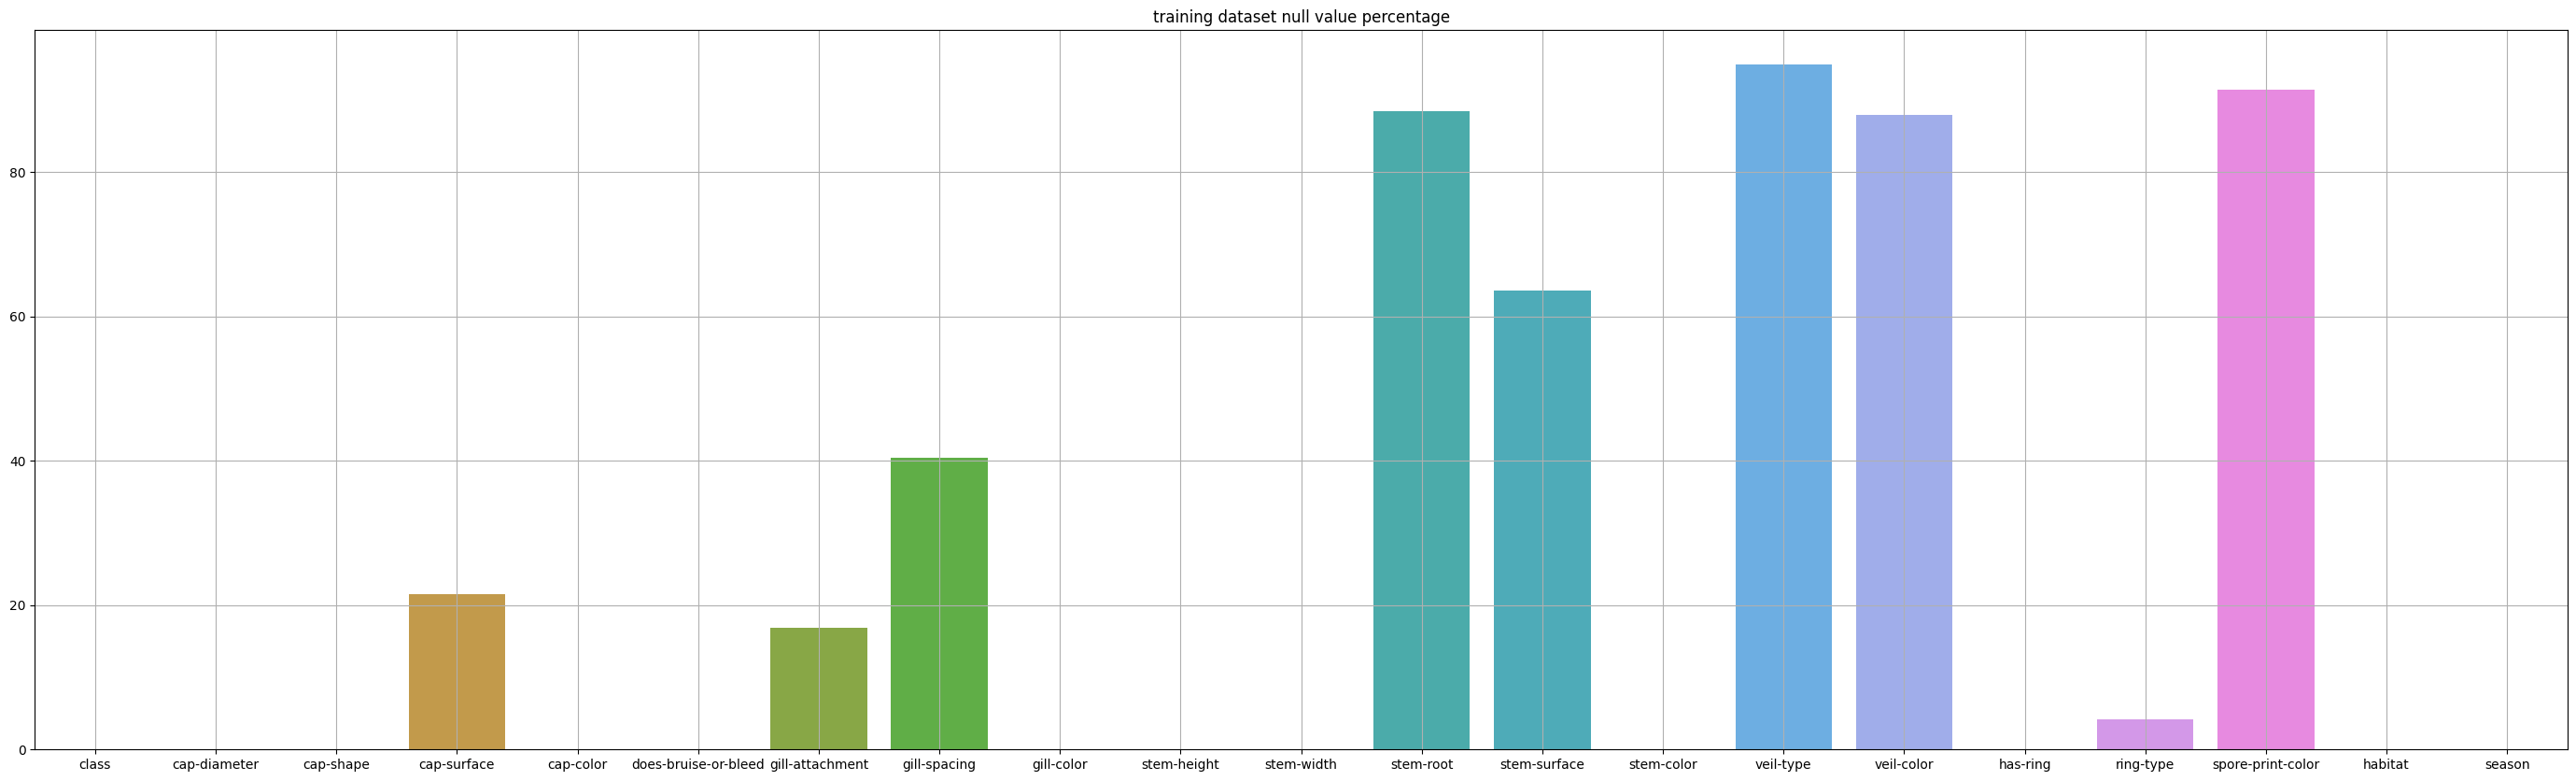

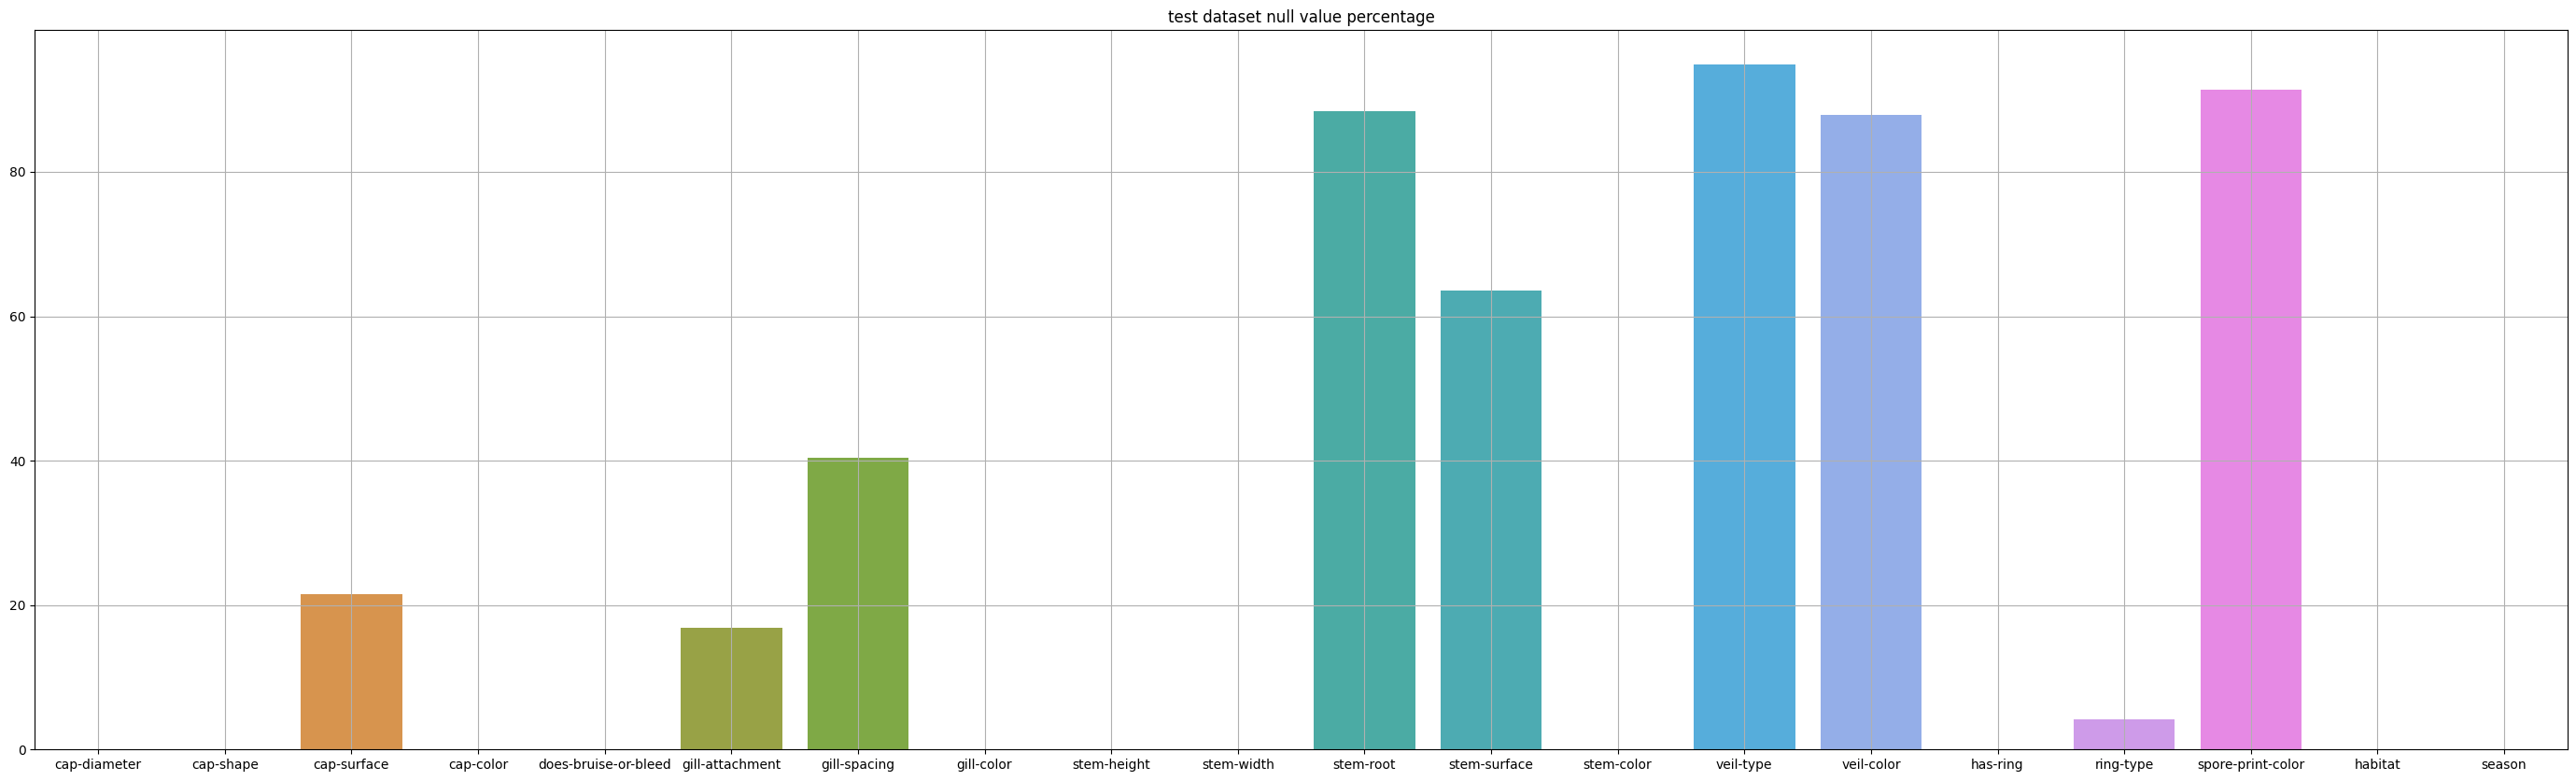

In [20]:
def percentage_null_values(dataset, feature_names):
    null_per = []
    for feat in feature_names:
        num_null = dataset[feat].isnull().sum()
        null_per_val = (num_null*100/(dataset.shape[0]))
        null_per.append(null_per_val)
    return null_per

per_nandataset = pd.Series(percentage_null_values(dataset_enc_filt, column_names), index=column_names)
print(f"training dataset null values:\n{per_nandataset}\n")

per_testnan_dataset = pd.Series(percentage_null_values(test_dataset_enc_fit, feature_names), index=feature_names)
print(f"test dataset null values:\n{per_testnan_dataset}\n")

fig = plt.figure(figsize=(35,10))
sns.barplot(x=train_dataset.columns, y=per_nandataset)
plt.title("training dataset null value percentage")
plt.grid()
plt.show()

fig = plt.figure(figsize=(35,10))
sns.barplot(x=test_dataset.columns, y=per_testnan_dataset)
plt.title("test dataset null value percentage")
plt.grid()
plt.show()

cap-diameter: 2.4422631775664954
stem-height: 4.256796318189766
stem-width: 2.1361942543099093


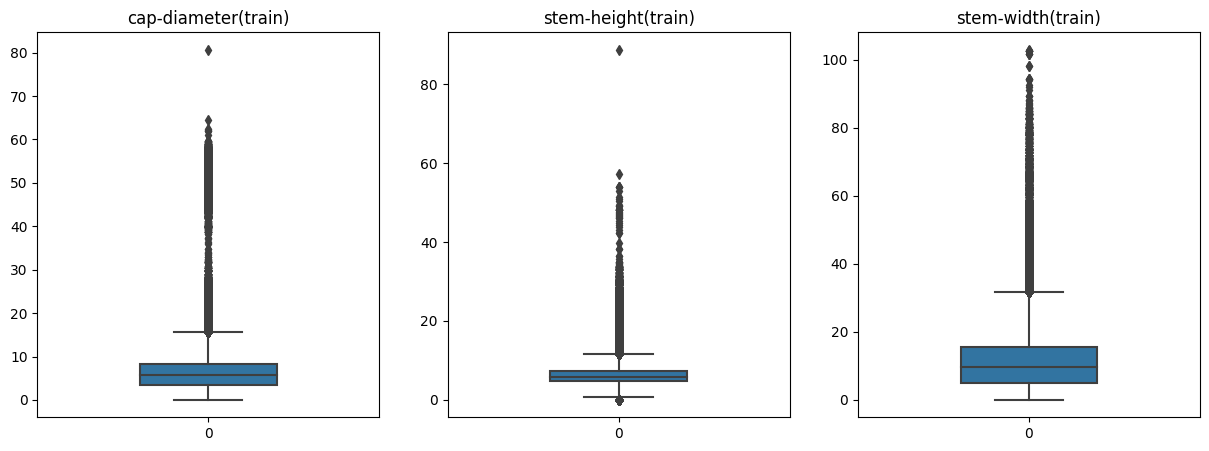

In [21]:
def percentage_outlier(dataset, feature_names):
    per_outlier = [] # applicable to numerical features --> non-categorical features
    for feature_name in feature_names:
        q1 = dataset[feature_name].quantile(0.25)
        q3 = dataset[feature_name].quantile(0.75)
        IQR = q3-q1

        val_out = dataset[feature_name][(dataset[feature_name] <= (q1-1.5*IQR)) | (dataset[feature_name] >= (q3+1.5*IQR))]
        out_per = (val_out.shape[0]*100)/dataset.shape[0]

        per_outlier.append((feature_name, out_per))
    return per_outlier

    
outlier_per = percentage_outlier(dataset_enc_filt, ['cap-diameter', 'stem-height', 'stem-width'])
for feat,out_per in outlier_per:
    print(f"{feat}: {out_per}")


fig, axearr = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(data=dataset_enc_filt['cap-diameter'], width=0.4, ax=axearr[0])
axearr[0].set_title('cap-diameter(train)')
sns.boxplot(data=dataset_enc_filt['stem-height'], width=0.4, ax=axearr[1])
axearr[1].set_title('stem-height(train)')
sns.boxplot(data=dataset_enc_filt['stem-width'], width=0.4, ax=axearr[2])
axearr[2].set_title('stem-width(train)')
plt.show()

cap-diameter: 2.4734307235351527
stem-height: 4.253490435830457
stem-width: 2.1543202865882183


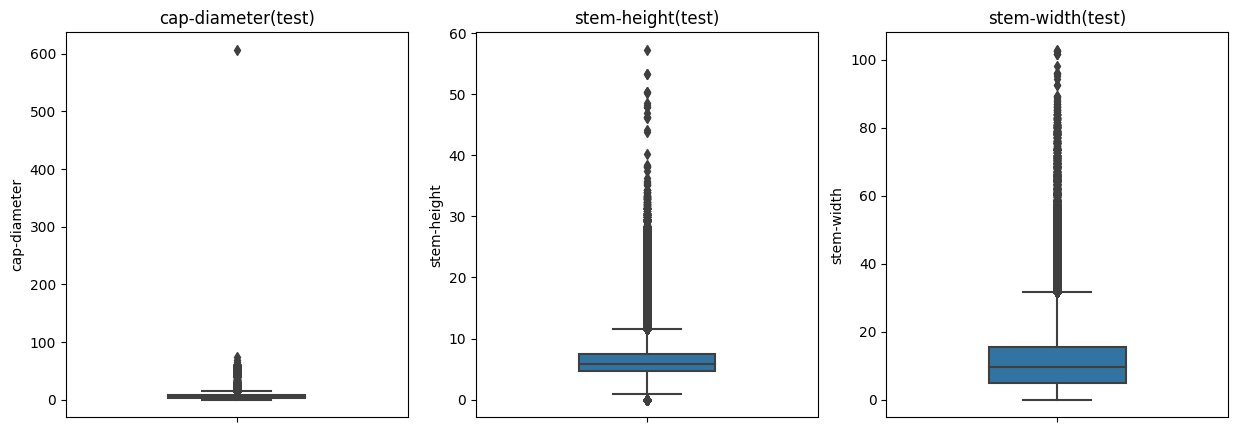

In [22]:
test_outlier_per = percentage_outlier(test_dataset_enc_fit, ['cap-diameter', 'stem-height', 'stem-width'])
for feat,out_per in test_outlier_per:
    print(f"{feat}: {out_per}")

fig, axearr = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(y=test_dataset_enc_fit['cap-diameter'], width=0.4, ax=axearr[0])
axearr[0].set_title('cap-diameter(test)')
sns.boxplot(y=test_dataset_enc_fit['stem-height'], width=0.4, ax=axearr[1])
axearr[1].set_title('stem-height(test)')
sns.boxplot(y=test_dataset_enc_fit['stem-width'], width=0.4, ax=axearr[2])
axearr[2].set_title('stem-width(test)')
plt.show()

In [ ]:
fig = plt.figure()
sns.pairplot(data=dataset_enc_filt.head(100), hue='class')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Figure size 640x480 with 0 Axes>

In [ ]:
# correlation map of features
fig = plt.figure(figsize=(30,30))
sns.heatmap(dataset_enc_filt.corr(method='pearson'), cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
def drop_features(dataset, features):
    dataset_copy = dataset.copy()
    for feat in features:
        dataset_copy.drop(columns=[feat], axis=1, inplace=True)
    return dataset_copy
        
def drop_null_values(dataset):
    dataset_copy = dataset.copy()
    dataset_copy.dropna(axis=0, inplace=True)
    return dataset_copy

def impute_feature_vals(dataset, features):
    dataset_copy = dataset.copy()
    imputer = KNNImputer(n_neighbors=5)
    for feat in features:
        dataset_copy[feat]=imputer.fit_transform(dataset_copy[[feat]])
    return dataset_copy
        

In [41]:
# handling null datas of the dataset
dataset_enc_nafilt = drop_features(dataset_enc_filt, ['cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color', 'ring-type'])
test_dataset_nafilt = drop_features(test_dataset_enc_fit, ['cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 'veil-color','spore-print-color', 'ring-type'])
dataset_enc_nafilt = impute_feature_vals(dataset_enc_nafilt, ['cap-diameter'])
test_dataset_nafilt = impute_feature_vals(test_dataset_nafilt, ['cap-diameter', 'cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color', 'stem-height', 'stem-color', 'has-ring', 'habitat'])

dataset_enc_fullfilt = drop_null_values(dataset_enc_nafilt)
test_dataset_fullfilt = test_dataset_nafilt.copy()

print(f"Train Dataset:\n{dataset_enc_nafilt.isnull().sum()}")
print(f"\nTest Dataset:\n{test_dataset_nafilt.isnull().sum()}")
print(f"*************************FULLY FILTERED******************************\n")
print(f"Train Dataset:\n{dataset_enc_fullfilt.isnull().sum()}")
print(f"\nTest Dataset:\n{test_dataset_fullfilt.isnull().sum()}")

Train Dataset:
class                    0
cap-diameter             0
cap-shape               40
cap-color               12
does-bruise-or-bleed     8
gill-color              57
stem-height              0
stem-width               0
stem-color              38
has-ring                24
habitat                 45
season                   0
dtype: int64

Test Dataset:
cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
habitat                 0
season                  0
dtype: int64
*************************FULLY FILTERED******************************

Train Dataset:
class                   0
cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring      

In [43]:
print(f"{dataset_enc_nafilt}")
print(f"\n********************************\nAfter filtering\n")
print(f"{dataset_enc_fullfilt}")

         class  cap-diameter  cap-shape  cap-color  does-bruise-or-bleed  \
id                                                                         
0            1          8.80        3.0       10.0                   1.0   
1            0          4.51        7.0        7.0                   1.0   
2            1          6.94        3.0        1.0                   1.0   
3            1          3.88        3.0        3.0                   1.0   
4            1          5.85        7.0       11.0                   1.0   
...        ...           ...        ...        ...                   ...   
3116940      1          9.29        3.0        6.0                   2.0   
3116941      1         10.88        6.0       11.0                   2.0   
3116942      0          7.82        7.0        2.0                   1.0   
3116943      1          9.45        5.0        6.0                   2.0   
3116944      0          3.20        7.0        3.0                   1.0   

         gi

In [44]:
print(f"{test_dataset_nafilt}")
print(f"\n********************************\nAfter filtering\n")
print(f"{test_dataset_fullfilt}")

         cap-diameter  cap-shape  cap-color  does-bruise-or-bleed  gill-color  \
id                                                                              
3116945          8.64        7.0        6.0                   2.0        11.0   
3116946          6.90        4.0        7.0                   1.0        12.0   
3116947          2.00        1.0        6.0                   1.0         6.0   
3116948          3.47        7.0        6.0                   1.0         6.0   
3116949          6.17        7.0       12.0                   1.0        12.0   
...               ...        ...        ...                   ...         ...   
5194904          0.88        7.0       11.0                   1.0        11.0   
5194905          3.12        7.0       11.0                   1.0        11.0   
5194906          5.73        7.0        2.0                   1.0        11.0   
5194907          5.03        1.0        6.0                   1.0         4.0   
5194908         15.51       

In [45]:
# splitting train dataset for training model
X = dataset_enc_fullfilt.drop(columns=['class'], axis=1, inplace=False)
y = dataset_enc_fullfilt['class']

print(f"input:\n{X}")
print(f"\noutput label:\n{y}")

input:
         cap-diameter  cap-shape  cap-color  does-bruise-or-bleed  gill-color  \
id                                                                              
0                8.80        3.0       10.0                   1.0        11.0   
1                4.51        7.0        7.0                   1.0         6.0   
2                6.94        3.0        1.0                   1.0        11.0   
3                3.88        3.0        3.0                   1.0         4.0   
4                5.85        7.0       11.0                   1.0        11.0   
...               ...        ...        ...                   ...         ...   
3116940          9.29        3.0        6.0                   2.0        11.0   
3116941         10.88        6.0       11.0                   2.0         8.0   
3116942          7.82        7.0        2.0                   1.0        11.0   
3116943          9.45        5.0        6.0                   2.0         8.0   
3116944          3.20

In [46]:
# train, validation split
#class_weights = {0: 1.3, 1: 1.0}
X_train, X_valid, y_train ,y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# using LogisticRegression model for training the dataset
rf_model = RandomForestClassifier(
    n_estimators=50,       # Number of trees in the forest
    criterion='entropy',       # Function to measure the quality of a split ('gini' or 'entropy')
    max_depth=None,         # Maximum depth of the tree (None means nodes are expanded until all leaves are pure or contain less than min_samples_split samples)
    min_samples_split=2,    # Minimum number of samples required to split an internal node
    min_samples_leaf=1,     # Minimum number of samples required to be at a leaf node
    bootstrap=True,         # Whether bootstrap samples are used when building trees
    verbose=3
)

#model = SGDClassifier(
   # loss='log_loss',
   # penalty='l2',
   # max_iter=1000,
    #alpha=0.0001,
   # tol=0.000001, 
   # verbose=3,
#)

# rf_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  4.5min


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


RandomForestClassifier(criterion='entropy', n_estimators=50, verbose=3)

In [47]:
y_pred = rf_model.predict(X_valid)
y_pred_train = rf_model.predict(X_train)

report_train = classification_report(y_train, y_pred_train)
report = classification_report(y_valid, y_pred)

print(f"Training prediction report:\n{report_train}")
print(f"Validation prediction report:\n{report}")

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   24.3s


Training prediction report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1193517
           1       1.00      1.00      1.00    988187

    accuracy                           1.00   2181704
   macro avg       1.00      1.00      1.00   2181704
weighted avg       1.00      1.00      1.00   2181704

Validation prediction report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    511764
           1       0.98      0.98      0.98    423253

    accuracy                           0.98    935017
   macro avg       0.98      0.98      0.98    935017
weighted avg       0.98      0.98      0.98    935017



In [48]:
X_test = test_dataset_fullfilt
print(f"{X_test}")

         cap-diameter  cap-shape  cap-color  does-bruise-or-bleed  gill-color  \
id                                                                              
3116945          8.64        7.0        6.0                   2.0        11.0   
3116946          6.90        4.0        7.0                   1.0        12.0   
3116947          2.00        1.0        6.0                   1.0         6.0   
3116948          3.47        7.0        6.0                   1.0         6.0   
3116949          6.17        7.0       12.0                   1.0        12.0   
...               ...        ...        ...                   ...         ...   
5194904          0.88        7.0       11.0                   1.0        11.0   
5194905          3.12        7.0       11.0                   1.0        11.0   
5194906          5.73        7.0        2.0                   1.0        11.0   
5194907          5.03        1.0        6.0                   1.0         4.0   
5194908         15.51       

In [49]:
predictions = rf_model.predict(X_test)

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   23.4s


In [50]:
submission = pd.DataFrame({'id': X_test.index , "class": predictions})
submission['class'] = submission['class'].map({0: 'p', 1: 'e'})
submission.to_csv("submission.csv", index=False)

print(submission)

              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [51]:
!head /kaggle/working/submission.csv

id,class
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e
3116950,e
3116951,e
3116952,p
3116953,p
